## Obiettivo

Il presente progetto ha come obiettivo l'analisi di un dataset proveniente da Spotify al fine di:

- Verificare la preferenza dell'utenza in relazione alla presenza o meno di contenuti espliciti nelle canzoni.
- Fare previsoni sulla popolarità di una canzone.
- Fare previsioni sulla popolarità di un 'artista.

---

## Fonte e struttura del dataset

Il dataset utilizzato è il **Spotify Dataset**, scaricato da [Kaggle](https://www.kaggle.com/).  
Questo set di dati fornisce una visione strutturata e pulita dei dati musicali di Spotify su due dimensioni chiave: **artisti** e **tracce**.  
È ideale per l'esplorazione, la visualizzazione e l'analisi dei dati musicali, nonché per progetti di machine learning.

Il dataset è costituito da **due file principali**:

---

### `artists.csv`

Contiene informazioni sui singoli artisti musicali:

- `id` : Identificatore univoco per ciascun artista.  
- `followers` : Numero di follower che l'artista ha su Spotify.  
- `genres` : Lista dei generi associati all'artista.  
- `name` : Nome dell'artista.  
- `popularity` : Punteggio numerico (da 0 a 100) che riflette la popolarità complessiva dell'artista su Spotify.

**Totale elementi**: 1.104.349 artisti.

---

### `tracks.csv`

Contiene dati relativi alle singole tracce musicali:

- `id` : Identificatore univoco per ogni traccia.  
- `name` : Nome o titolo della traccia.  
- `popularity` : Popolarità della traccia su Spotify (valore da 0 a 100).  
- `duration_ms` : Durata della traccia in millisecondi.  
- `explicit` : Indicatore booleano che segnala la presenza di contenuti espliciti.  
- `artists` : Lista degli artisti che hanno composto la traccia.  
- `id_artists` : Lista degli ID degli artisti coinvolti nella traccia.  
- `release_date` : Data di pubblicazione della traccia (formato YYYY-MM-DD).  
- `danceability`, `energy` : Caratteristiche audio calcolate da Spotify che rappresentano il "feeling" musicale del brano.

**Totale elementi**: 586.672 canzoni.

---

In [124]:
import kagglehub
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import os
import ast
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

In [125]:

path = kagglehub.dataset_download("nimishasen27/spotify-dataset")

print("Path to dataset files:", path)

Path to dataset files: /Users/ambro/.cache/kagglehub/datasets/nimishasen27/spotify-dataset/versions/1


In [126]:

dataArtists = pd.read_csv(os.path.join(path, "artists.csv"))
dataTracks = pd.read_csv(os.path.join(path, "tracks.csv"))

## Modifica del dataset

Una volta scaricati i due file (`artists.csv` e `tracks.csv`), sono state apportate alcune modifiche preliminari ai dati per facilitarne l'analisi:

- **Eliminazione delle colonne superflue**: sono stati rimossi alcuni identificatori univoci ritenuti non necessari per l'analisi, al fine di semplificare la struttura dei dataset.
  
- **Pulizia della colonna `genres` in `artists.csv`**: per garantire uniformità nei dati, è stato assegnato il valore `"Unknown"` alle righe in cui la colonna `genres` risultava vuota o mancante.
  
- **Conversione delle stringhe in liste**: i valori nella colonna `genres`, originariamente memorizzati come stringhe, sono stati convertiti in vere e proprie liste Python, così da consentire una manipolazione più agevole durante le analisi.



In [127]:

artists = pd.DataFrame({
    "followers" : dataArtists["followers"],
    "genres"    : dataArtists["genres"],
    "name"      : dataArtists["name"],
    "popularity": dataArtists["popularity"]
})

tracks = pd.DataFrame({
    "name"         : dataTracks["name"],
    "popularity"   : dataTracks["popularity"],
    "duration_ms"  : dataTracks["duration_ms"],
    "explicit"     : dataTracks["explicit"],
    "artists"      : dataTracks["artists"],
    "release_date" : dataTracks["release_date"],
    "danceability" : dataTracks["danceability"],
    "energy"       : dataTracks["energy"]
})

In [128]:

def parse_genres(val):
    try:
        parsed = ast.literal_eval(val)
        return parsed if isinstance(parsed, list) else []
    except:
        return []

artists['genres_list'] = artists['genres'].apply(parse_genres)
artists['genres_list'] = artists['genres_list'].apply(lambda g: g if isinstance(g, list) and len(g) > 0 else ['unknown'])
artists.drop(columns=['genres'], inplace=True)
artists = artists.sort_values(by='popularity', ascending=False).drop_duplicates(subset='name', keep='first')

In [129]:
artists.head(5)


,followers,name,popularity,genres_list
144481,44606973.0,Justin Bieber,100,"[canadian pop, pop, post-teen pop]"
115489,32244734.0,Bad Bunny,98,"[latin, reggaeton, trap latino]"
126338,38869193.0,Taylor Swift,98,"[pop, post-teen pop]"
313676,54416812.0,Drake,98,"[canadian hip hop, canadian pop, hip hop, pop ..."
144484,31623813.0,BTS,96,"[k-pop, k-pop boy group]"


In [130]:
tracks['release_date'] = pd.to_datetime(tracks['release_date'], errors='coerce')
tracks['year'] = tracks['release_date'].dt.year
tracks.drop(columns='release_date', inplace=True)
tracks

,name,popularity,duration_ms,explicit,artists,danceability,energy,year
0,Carve,6,126903,0,['Uli'],0.645,0.4450,1922.0
1,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],0.695,0.2630,1922.0
2,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],0.434,0.1770,1922.0
3,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],0.321,0.0946,1922.0
4,Lady of the Evening,0,163080,0,['Dick Haymes'],0.402,0.1580,NaN
...,...,...,...,...,...,...,...,...
586667,云与海,50,258267,0,['阿YueYue'],0.560,0.5180,2020.0
586668,blind,72,153293,0,['ROLE MODEL'],0.765,0.6630,2020.0
586669,What They'll Say About Us,70,187601,0,['FINNEAS'],0.535,0.3140,2020.0
586670,A Day At A Time,58,142003,0,"['Gentle Bones', 'Clara Benin']",0.696,0.6150,2021.0


##  Analisi Statistica del Dataset Artisti

Di seguito vengono analizzate le principali statistiche descrittive riferite al dataset degli artisti, con particolare attenzione a follower, popolarità e presenza di generi.

---

###  Follower

- **Media**: ~10.965 follower per artista
- **Mediana (50%)**: ~59 follower
- **25° percentile**: 10 follower
- **75° percentile**: 451 follower
- **Valore massimo**: 78.900.230 follower

 **Interpretazione**:
La distribuzione dei follower è fortemente sbilanciata: la maggior parte degli artisti ha pochi follower, mentre pochi artisti (outlier) concentrano gran parte della visibilità su Spotify. Il valore medio è gonfiato da questi outlier, come dimostrano i quartili bassi (il 75% degli artisti ha meno di 451 follower).

---

###  Popolarità

- **Media**: ~9.08 su una scala 0–100
- **Mediana (50%)**: 2
- **75° percentile**: 14
- **Valore massimo**: 100

 **Interpretazione**:
Anche la popolarità presenta una distribuzione **asimmetrica e molto bassa**. Il 50% degli artisti ha una popolarità inferiore a 2, quindi si tratta probabilmente di artisti emergenti o poco ascoltati. Solo una piccola parte raggiunge livelli elevati di popolarità (vicini a 100).

---

###  Generi (genres_list)

- **Generi unici**: 48.419
- **Genere più comune**: `[unknown]` (785.439 artisti)

 **Interpretazione**:
La maggior parte degli artisti nel dataset **non ha un genere assegnato** da Spotify (`[unknown]`), probabilmente perché si tratta di artisti indipendenti, poco noti o con pochi dati di ascolto. Questo elemento è importante da considerare nelle analisi successive: sarà opportuno **escludere gli "unknown"** nelle analisi sui generi per evitare distorsioni.

---

###  Nomi degli artisti

- **Nomi unici**: 1.078.659 su 1.078.660 righe
- **Nome più frequente**: Justin Bieber (una sola occorrenza, ma è il top per follower e popolarità)

 **Interpretazione**:
La presenza quasi perfetta di nomi univoci suggerisce una buona copertura del dataset, anche se potrebbero esistere omonimie (es. artisti diversi con lo stesso nome). La qualità è comunque elevata per analisi aggregate.


In [131]:

print(" Statistiche Artisti")
print(artists.describe(include='all'))

 Statistiche Artisti
           followers           name    popularity genres_list
count   1.078649e+06        1078659  1.078660e+06     1078660
unique           NaN        1078659           NaN       48419
top              NaN  Justin Bieber           NaN   [unknown]
freq             NaN              1           NaN      785439
mean    1.096498e+04            NaN  9.085396e+00         NaN
std     2.640323e+05            NaN  1.381896e+01         NaN
min     0.000000e+00            NaN  0.000000e+00         NaN
25%     1.000000e+01            NaN  0.000000e+00         NaN
50%     5.900000e+01            NaN  2.000000e+00         NaN
75%     4.510000e+02            NaN  1.400000e+01         NaN
max     7.890023e+07            NaN  1.000000e+02         NaN


##  Analisi Statistica del Dataset Tracce

Analizziamo ora le statistiche descrittive del dataset delle tracce, considerando variabili come popolarità, durata, caratteristiche audio (`danceability`, `energy`) e contenuto esplicito.

---

###  Popolarità

- **Media**: ~27.57  
- **Mediana (50%)**: 27  
- **Massimo**: 100  
- **25° percentile**: 13  
- **75° percentile**: 41

 **Interpretazione**:  
La distribuzione è abbastanza ampia, ma **concentrata verso il basso**: il 75% delle tracce ha una popolarità inferiore a 41. Solo poche tracce raggiungono la massima popolarità (100), indicando che la maggior parte dei brani ha un impatto limitato sulla piattaforma.

---

###  Durata (in millisecondi)

- **Media**: ~230.051 ms ≈ **3 min e 50 sec**  
- **Mediana**: ~214.893 ms ≈ **3 min e 35 sec**  
- **Massimo**: 5.621.218 ms ≈ **1 ora e 34 minuti**  
- **Minimo**: ~3.344 ms

 **Interpretazione**:  
La durata media è coerente con i formati radiofonici o da playlist. Tuttavia, esistono outlier con durate molto elevate (oltre 1 ora) o bassissime (pochi secondi), che potrebbero essere **audio tecnici, effetti sonori o errori**.

---

###  Contenuti Espliciti

- **Espliciti**: 4.4% delle tracce (`explicit = 1`)  
- **Non espliciti**: 95.6%

 **Interpretazione**:  
La grande maggioranza dei brani è priva di contenuti espliciti. Tuttavia, la presenza anche di una minoranza significativa (4.4%) giustifica l’analisi comparativa tra tracce esplicite e pulite in termini di popolarità o caratteristiche audio.

---

###  Caratteristiche Audio

####  Danceability (0–1)

- **Media**: 0.563  
- **Mediana**: 0.577  
- **Max**: 0.991

 **Interpretazione**:  
In media, le tracce sono **moderatamente ballabili**, con valori centrati attorno a 0.56–0.58. Esistono sia brani molto ballabili (> 0.9) che brani statici (valori bassi), suggerendo una buona varietà.

####  Energy (0–1)

- **Media**: 0.542  
- **Mediana**: 0.549  
- **Max**: 1.0

 **Interpretazione**:  
Anche l’energia ha una distribuzione centrale. Tracce molto energiche (valori > 0.8) esistono, ma la media suggerisce che Spotify include anche molti brani soft o rilassati nel catalogo.

---

### 👤 Artisti e Nomi

- **Nomi unici di tracce**: 446.474  
- **Artisti unici** (liste): 114.030  
- **Traccia più frequente**: `"Summertime"` (101 volte)  
- **Artista più ricorrente**: `"Die drei ???"` (3.856 volte)

 **Interpretazione**:  
Alcuni brani o artisti appaiono più volte, probabilmente per **versioni diverse, remix o album multipli**.


In [132]:

print("\n Statistiche Tracce")
print(tracks.describe(include='all'))


 Statistiche Tracce
              name     popularity   duration_ms       explicit  \
count       586601  586672.000000  5.866720e+05  586672.000000   
unique      446474            NaN           NaN            NaN   
top     Summertime            NaN           NaN            NaN   
freq           101            NaN           NaN            NaN   
mean           NaN      27.570053  2.300512e+05       0.044086   
std            NaN      18.370642  1.265261e+05       0.205286   
min            NaN       0.000000  3.344000e+03       0.000000   
25%            NaN      13.000000  1.750930e+05       0.000000   
50%            NaN      27.000000  2.148930e+05       0.000000   
75%            NaN      41.000000  2.638670e+05       0.000000   
max            NaN     100.000000  5.621218e+06       1.000000   

                 artists   danceability         energy           year  
count             586672  586672.000000  586672.000000  448081.000000  
unique            114030            NaN   

## Analisi della distribuzione degli artisti

Di seguito sono riportati i grafici relativi alla distribuzione della popolarità e del numero di follower degli artisti presenti nel dataset `artists.csv`.

---

###  Distribuzione della popolarità degli artisti


- La maggior parte degli artisti ha un punteggio di **popolarità molto basso**, concentrato tra 0 e 10.
- La distribuzione è **fortemente asimmetrica (skewed a destra)**: pochissimi artisti raggiungono punteggi alti (oltre 50).
- La **curva KDE** (in blu) conferma che la popolarità segue una distribuzione a coda lunga, dove solo una piccolissima parte degli artisti è davvero popolare.
- Questo riflette una realtà comune nel mercato musicale: pochi artisti ottengono la maggior parte dell'attenzione del pubblico, mentre la stragrande maggioranza resta poco conosciuta.

---

###  Distribuzione dei follower degli artisti

- Il numero di follower presenta una **forte asimmetria**: la maggior parte degli artisti ha pochi follower, mentre una piccola parte ne ha milioni.
- La trasformazione logaritmica in base 10 aiuta a **rendere visibile la struttura dei dati**, riducendo l'effetto della coda lunga verso destra.
- L’aggiunta di `+1` serve a evitare problemi con i valori pari a zero, poiché il logaritmo di 0 non è definito.

###  Dettagli del grafico
- **Asse X**: rappresenta `log10(followers + 1)`. Alcuni esempi di interpretazione:
  - `log10(1) = 0` → 0 follower reali
  - `log10(10) = 1` → circa 9 follower
  - `log10(1000) = 3` → circa 999 follower
  - `log10(1.000.000) = 6` → circa 1 milione di follower
- **Asse Y**: rappresenta il **conteggio** degli artisti (frequenza) per ciascun intervallo (bin).

###  Osservazioni
- La maggior parte degli artisti ha un valore compreso tra `log10(followers + 1) ≈ 1` e `2`, cioè tra circa **10 e 100 follower reali**.
- La distribuzione è **asimmetrica** e decresce verso destra, confermando che solo una piccola percentuale di artisti raggiunge un pubblico molto ampio.
- La curva di densità evidenzia una **modalità netta** seguita da un lento decadimento, tipico delle distribuzioni "power-law" nei dati social.

---

###  Conclusioni

- Entrambe le variabili (`popularity` e `followers`) mostrano una **forte concentrazione in valori bassi**, confermando la presenza di **grande disparità** tra artisti affermati e artisti emergenti o poco noti.


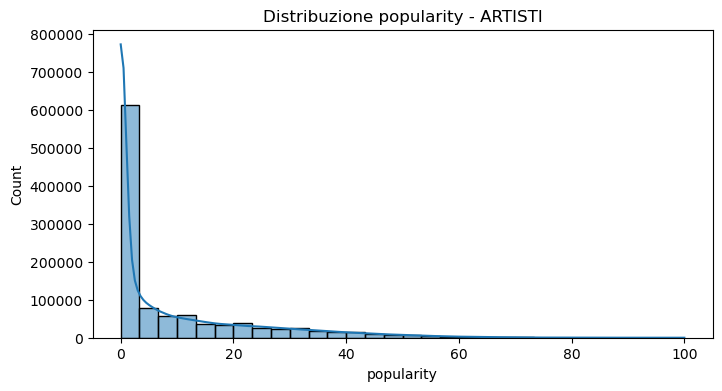

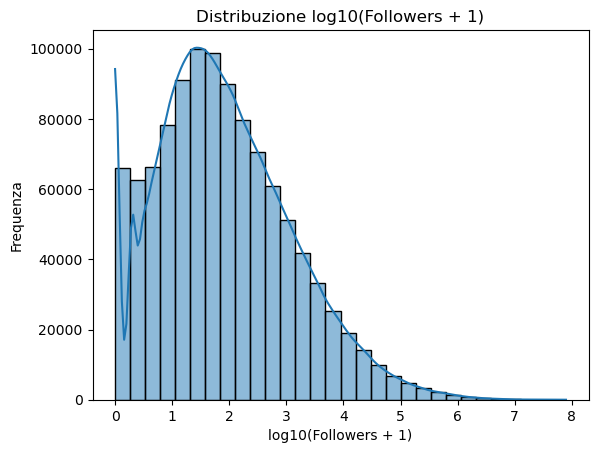

In [133]:

numerical_columns = ['popularity']
for col in numerical_columns:
    plt.figure(figsize=(8,4))
    sns.histplot(artists[col], bins=30, kde=True)
    plt.title(f'Distribuzione {col} - ARTISTI')
    plt.show()

sns.histplot(np.log10(artists['followers'] + 1), bins=30, kde=True)
plt.title('Distribuzione log10(Followers + 1)')
plt.xlabel('log10(Followers + 1)')
plt.ylabel('Frequenza')
plt.show()

## Analisi della distribuzione delle tracce
Di seguito sono riportati i grafici della distribuzione relativi alla popularity,duration_ms,danceability e energy.

---

### Distribuzione popularity
Osservazioni:
- Distribuzione fortemente asimmetrica: La maggior parte delle tracce (oltre 60,000) ha una popolarità molto bassa (0-20)
- Coda lunga verso valori alti: Solo una piccola frazione di tracce raggiunge popolarità elevate (70+)
- Picco minimo: Nessuna traccia raggiunge il valore massimo teorico di 100

---
### Distribuzione duration_ms
Osservazioni:
- Distribuzione esponenziale: Frequenza decrescente all'aumentare della durata
- Picco nella fascia breve: Oltre 600,000 tracce sotto 1e6 ms (≈16.7 minuti)
---
### Distribuzione danceability
Osservazioni:
- Distribuzione normale: Forma approssimativamente gaussiana
- Picco centrale: Massima concentrazione tra 0.4-0.6
- Code simmetriche: Frequenza decrescente verso valori estremi (0.0 e 1.0)
---
### Distribuzione energy
Osservazioni:
- La maggior parte delle tracce ha un valore di energia compreso tra 0.3 e 0.8.
- C’è una minore presenza di brani estremamente calmi (energy ~0) o estremamente energici (energy ~1),** ma comunque presenti.
- Il picco si registra intorno a 0.55, coerente con la media ~0.54 del dataset.



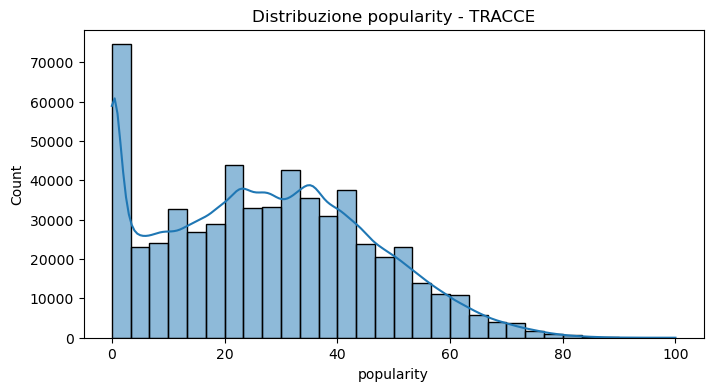

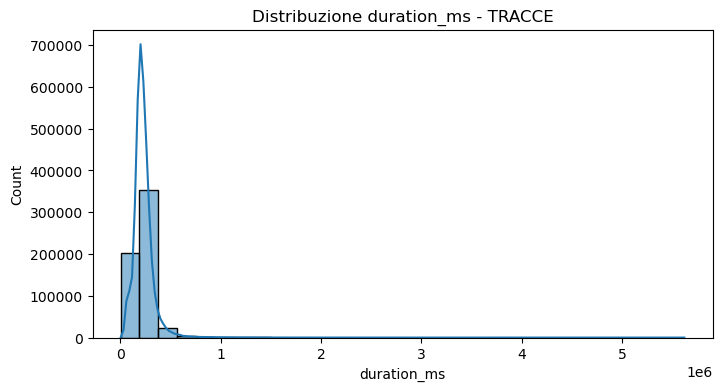

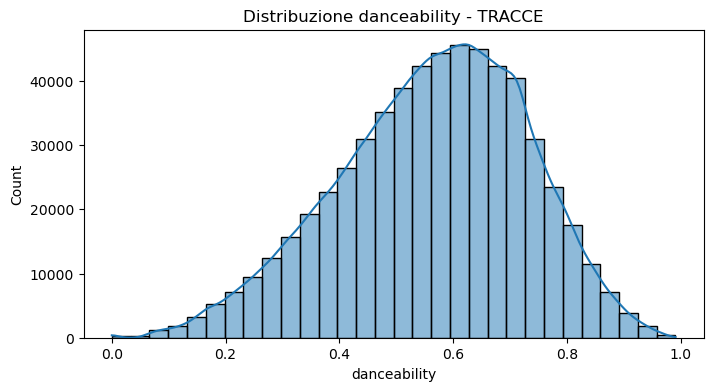

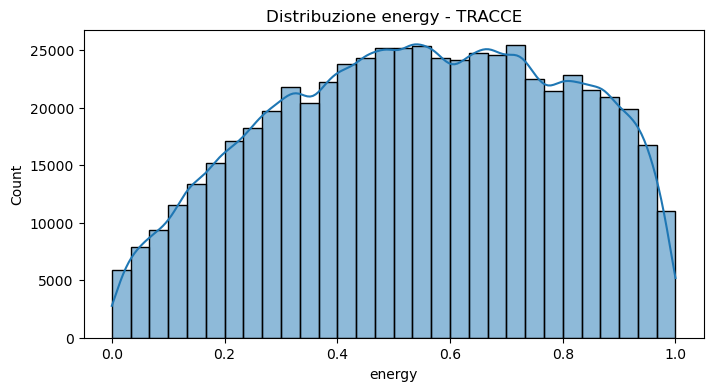

In [134]:
numerical_columns = ['popularity', 'duration_ms', 'danceability', 'energy']
for col in numerical_columns:
    plt.figure(figsize=(8,4))
    sns.histplot(tracks[col], bins=30, kde=True)
    plt.title(f'Distribuzione {col} - TRACCE')
    plt.show()

## Analisi della Distribuzione di Contenuti Espliciti

### Panoramica del Grafico
Il grafico a torta mostra la proporzione tra tracce **"clean"** (non esplicite) e **"explicit"** (contenuto esplicito) nel dataset:

- **Clean**: 95.6% (dominante)
- **Explicit**: 4.4% (minoritario)

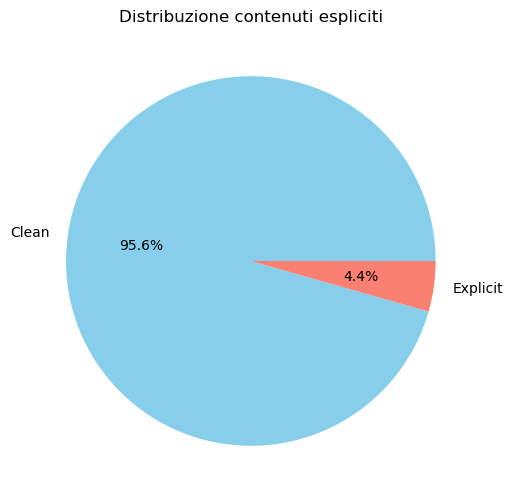

In [135]:

plt.figure(figsize=(6,6))
tracks['explicit'].value_counts().plot.pie(autopct='%1.1f%%', labels=['Clean', 'Explicit'], colors=['skyblue', 'salmon'])
plt.title('Distribuzione contenuti espliciti')
plt.ylabel('')
plt.show()

# Analisi della Matrice di Correlazione tra Feature Musicali

## Struttura della Matrice
La matrice mostra le correlazioni (coefficienti di Pearson) tra 4 variabili del dataset delle tracce.

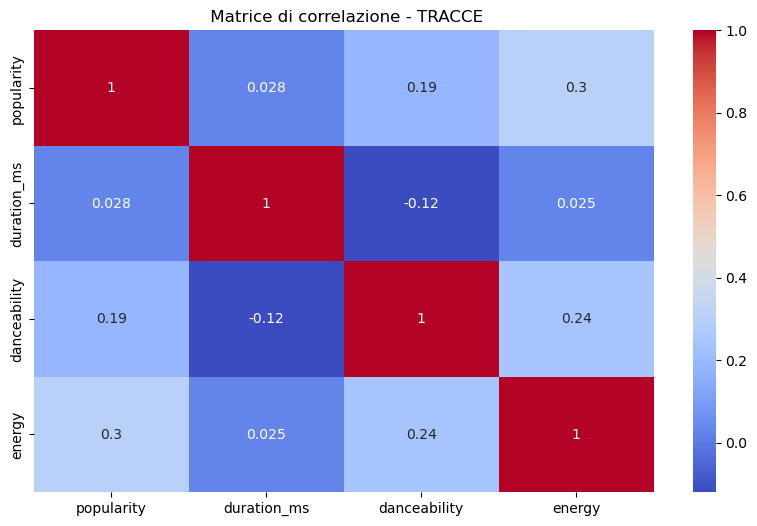

In [136]:

plt.figure(figsize=(10,6))
sns.heatmap(tracks[['popularity', 'duration_ms', 'danceability', 'energy']].corr(), annot=True, cmap='coolwarm')
plt.title(' Matrice di correlazione - TRACCE')
plt.show()

## Grafico a dispersione delle tracce
Ogni punto rappresenta un brano e la posizione del punto indica:
- quanto è ballabile (asse x)
- quanto è energico (asse y)
- Il colore indica se è un brano esplicito (explicit = 1) o pulito (explicit = 0)

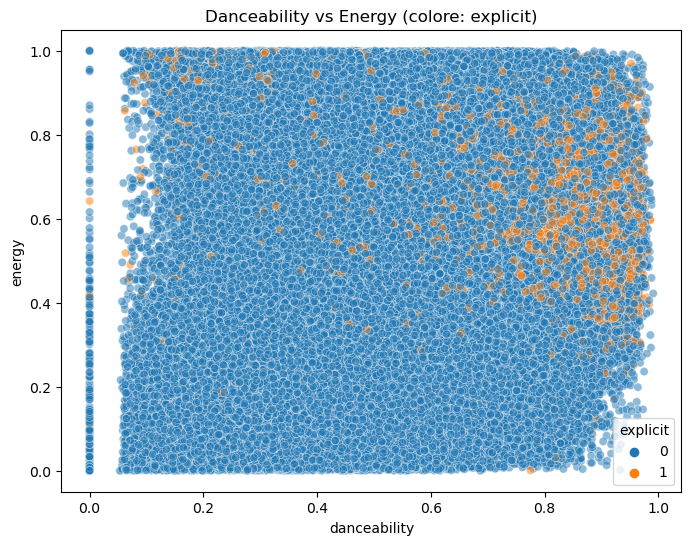

In [137]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=tracks, x='danceability', y='energy', hue='explicit', alpha=0.5)
plt.title('Danceability vs Energy (colore: explicit)')
plt.show()

## Top 10 Artisti più seguiti su Spotify

Il seguente grafico mostra i **10 artisti con il maggior numero di follower** su Spotify, ordinati in modo decrescente.  
Per ogni artista viene visualizzata una barra proporzionale al numero di follower.

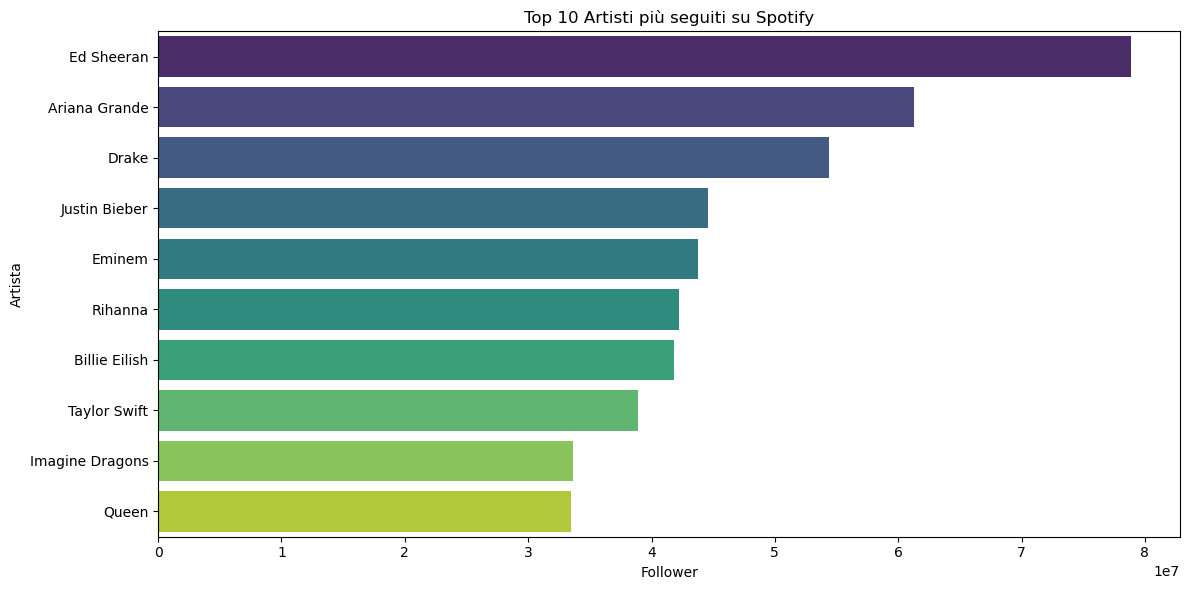

In [138]:
top_followed_artists = artists.sort_values(by='followers', ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(x='followers', y='name', data=top_followed_artists, palette='viridis')
plt.title('Top 10 Artisti più seguiti su Spotify')
plt.xlabel('Follower')
plt.ylabel('Artista')
plt.tight_layout()
plt.show()

##  Top 10 Generi più Popolari su Spotify (in base alla somma della popolarità degli artisti)

Questo grafico rappresenta i **10 generi musicali più popolari** nel dataset, misurati in base alla **somma della popolarità degli artisti** associati a ciascun genere.

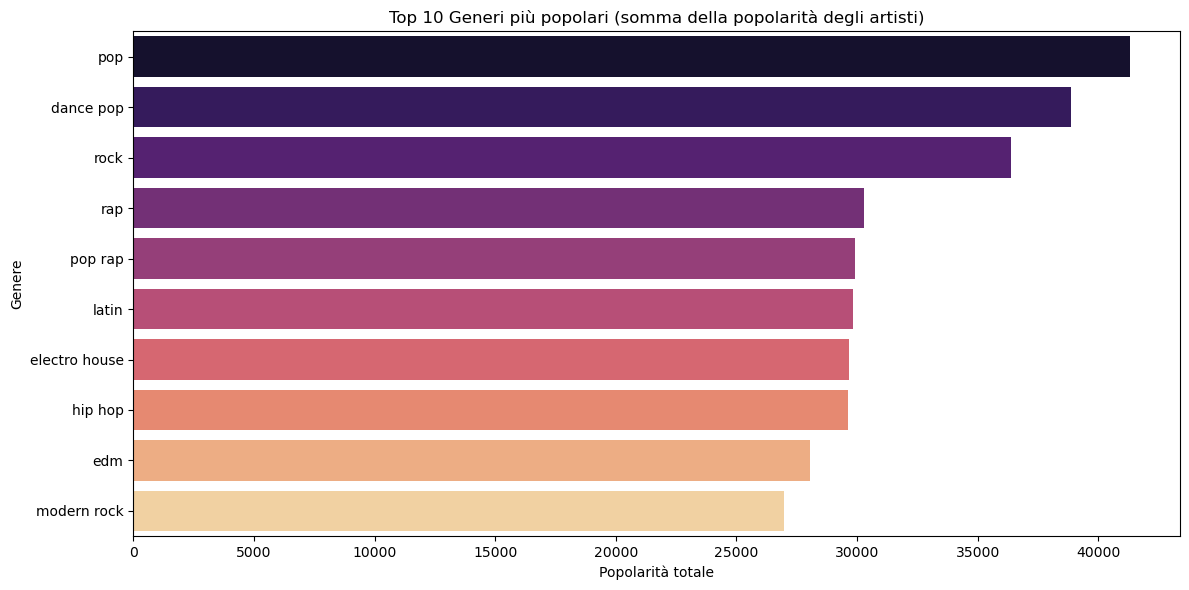

In [139]:

genre_popularity = []

for _, row in artists.iterrows():
    for genre in row['genres_list']:
        if genre != 'unknown':
            genre_popularity.append((genre, row['popularity']))

genre_df = pd.DataFrame(genre_popularity, columns=['genre', 'popularity'])
top_genres = genre_df.groupby('genre').sum().sort_values('popularity', ascending=False).head(10).reset_index()

plt.figure(figsize=(12,6))
sns.barplot(x='popularity', y='genre', data=top_genres, palette='magma')
plt.title('Top 10 Generi più popolari (somma della popolarità degli artisti)')
plt.xlabel('Popolarità totale')
plt.ylabel('Genere')
plt.tight_layout()
plt.show()

## Analisi popolarità,energy e danceability tra brani espliciti e clean
In questa sezione viene effettuata un’analisi comparativa e di distribuzione tra le canzoni esplicite e non esplicite (clean) all’interno del dataset tracks.

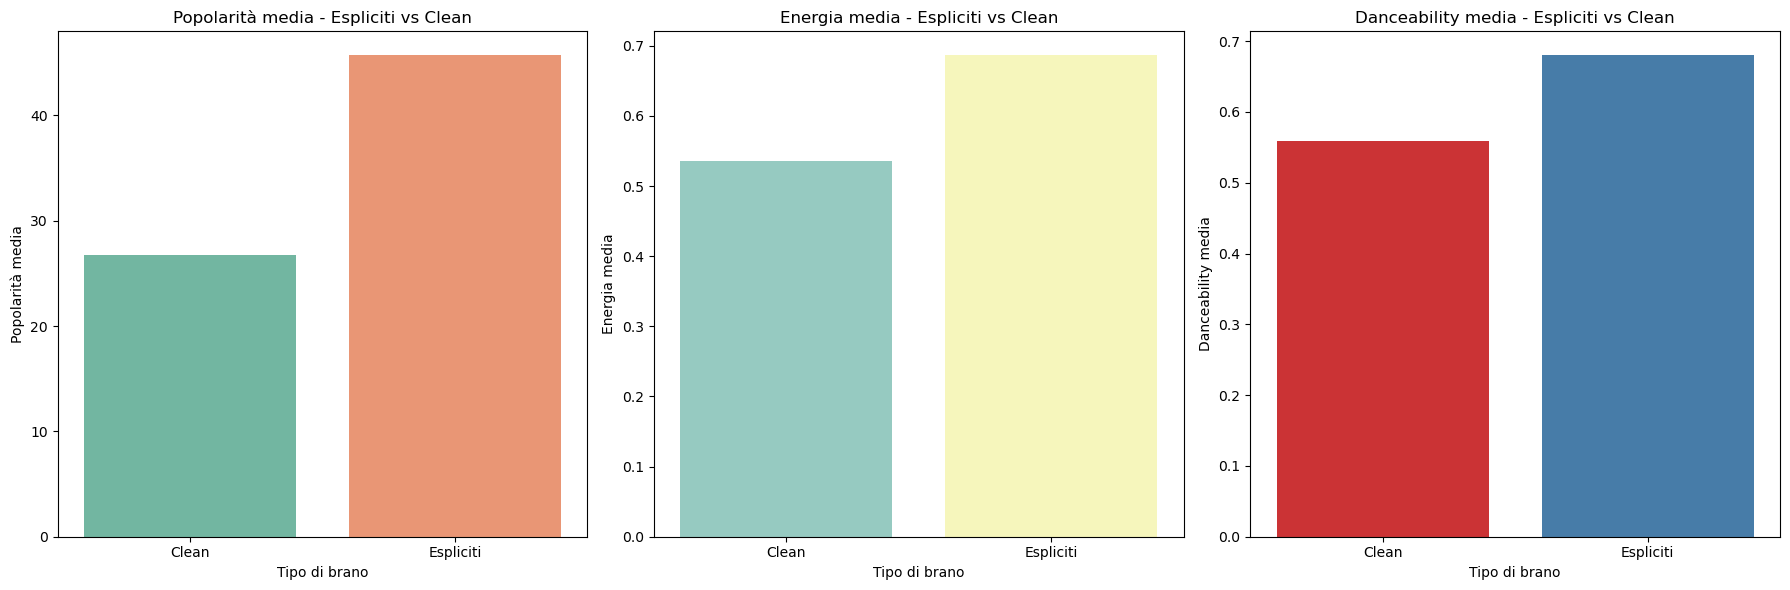

In [140]:

grouped = tracks.groupby('explicit').agg({
    'popularity': 'mean',
    'energy': 'mean',
    'danceability': 'mean'
}).reset_index()

grouped['explicit'] = grouped['explicit'].map({1: 'Espliciti', 0: 'Clean'})
grouped['explicit'] = grouped['explicit'].fillna('Sconosciuto')

fig, ax = plt.subplots(1, 3, figsize=(18,6))

sns.barplot(x='explicit', y='popularity', data=grouped, ax=ax[0], palette='Set2')
ax[0].set_title('Popolarità media - Espliciti vs Clean')
ax[0].set_ylabel('Popolarità media')
ax[0].set_xlabel('Tipo di brano')

sns.barplot(x='explicit', y='energy', data=grouped, ax=ax[1], palette='Set3')
ax[1].set_title('Energia media - Espliciti vs Clean')
ax[1].set_ylabel('Energia media')
ax[1].set_xlabel('Tipo di brano')

sns.barplot(x='explicit', y='danceability', data=grouped, ax=ax[2], palette='Set1')
ax[2].set_title('Danceability media - Espliciti vs Clean')
ax[2].set_ylabel('Danceability media')
ax[2].set_xlabel('Tipo di brano')

plt.tight_layout()
plt.show()

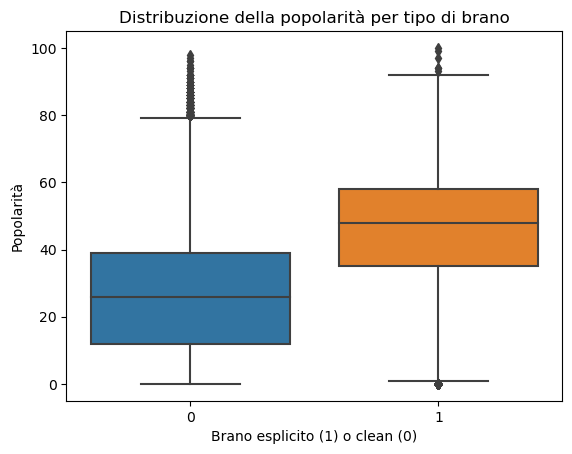

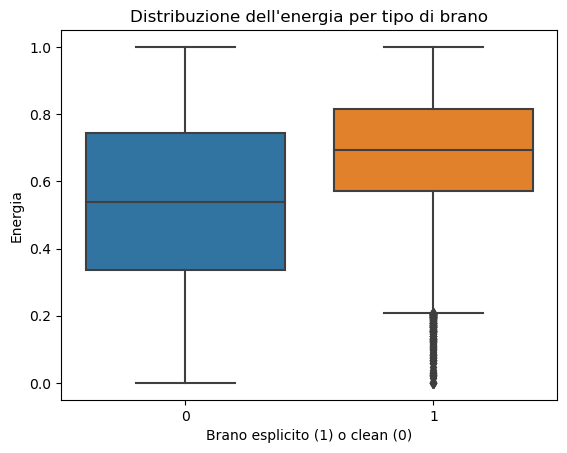

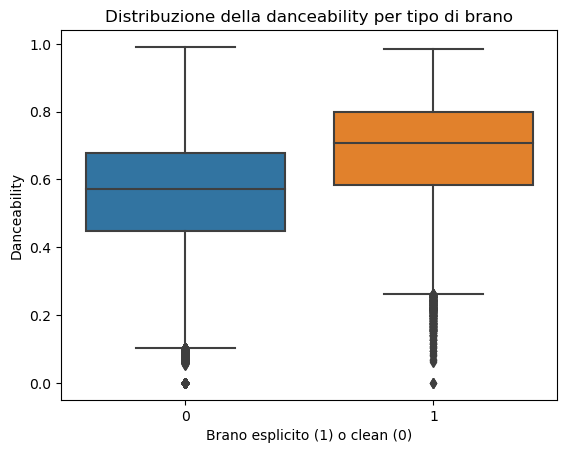

In [141]:

sns.boxplot(x='explicit', y='popularity', data=tracks)
plt.title('Distribuzione della popolarità per tipo di brano')
plt.xlabel('Brano esplicito (1) o clean (0)')
plt.ylabel('Popolarità')
plt.show()

sns.boxplot(x='explicit', y='energy', data=tracks)
plt.title('Distribuzione dell\'energia per tipo di brano')
plt.xlabel('Brano esplicito (1) o clean (0)')
plt.ylabel('Energia')
plt.show()

sns.boxplot(x='explicit', y='danceability', data=tracks)
plt.title('Distribuzione della danceability per tipo di brano')
plt.xlabel('Brano esplicito (1) o clean (0)')
plt.ylabel('Danceability')
plt.show()

# Predizione della popolarità dei brani su Spotify

## Obiettivo  
Utilizzare le caratteristiche audio e anagrafiche di tracce e artisti per predire la popolarità di un brano su Spotify.

## Dati utilizzati  
- **Dataset tracks**: contiene informazioni sui brani (popolarità, durata, danceability, energy, explicit, anno, ecc.).  
- **Dataset artists**: contiene informazioni sugli artisti (numero di follower, generi, popolarità, ecc.).

## Preprocessing  
- Sono stati considerati solo i brani con tutte le feature valide e con popolarità maggiore di zero.  
- Le liste di artisti sono state esplose per associare correttamente ogni traccia a ciascun artista.  
- È stata effettuata una fusione (merge) tra i dataset *tracks* e *artists* tramite il nome dell’artista.

## Analisi dei risultati  
- **Regressione lineare**:  
  - Il modello spiega circa il 49% della varianza nella popolarità, rappresentando una base di partenza valida ma non ottimale.  
  - Essendo un modello lineare, non riesce a catturare relazioni non lineari tra le variabili.  
  - Le feature più influenti risultano essere *danceability* ed *explicit*.  
  - Il coefficiente negativo associato a *energy* potrebbe derivare da una correlazione inversa con altri fattori o dalle caratteristiche specifiche del dataset.

- **Random Forest**:  
  - Presenta un MSE inferiore (101.84) e un R² pari a 0.688, risultando quindi più preciso rispetto alla regressione lineare.  
  - Le predizioni sono distribuite più uniformemente lungo la diagonale, segno che il modello cattura efficacemente le non linearità presenti nei dati.  
  - È particolarmente adatto a dataset misti con variabili continue e categoriche.

- **Gradient Boosting**:  
  - Raggiunge un R² di 0.573, inferiore rispetto alla Random Forest ma superiore alla regressione lineare.  
  - Offre una maggiore regolarizzazione rispetto alla Random Forest, risultando meno potente nelle predizioni più alte.  
  - Rappresenta un buon compromesso tra accuratezza e interpretabilità del modello.

In [142]:

def safe_parse(val):
    try:
        return ast.literal_eval(val) if isinstance(val, str) else val
    except:
        return []

tracks['artists'] = tracks['artists'].apply(safe_parse)

# Funzione per creare un DataFrame con importanza/coefficiente
def get_feature_importance(model, feature_names):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    else:
        importances = np.abs(model.coef_) 
    return pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values(by='importance', ascending=False)

In [143]:
required = ['popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'year']
tracks_clean = tracks.dropna(subset=required)
tracks_clean = tracks_clean[tracks_clean['popularity'] > 0]
tracks_clean = tracks_clean.explode('artists')
merged = tracks_clean.merge(
    artists,
    left_on='artists',
    right_on='name',
    suffixes=('_track', '_artist')
)
merged.head(5)

,name_track,popularity_track,duration_ms,explicit,artists,danceability,energy,year,followers,name_artist,popularity_artist,genres_list
0,Carve,6,126903,0,Uli,0.645,0.445,1922.0,28721.0,Uli,18,[unknown]
1,Hicran,1,204173,0,Safiye Ayla,0.227,0.423,1923.0,36040.0,Safiye Ayla,32,"[turkish classical, turkish jazz]"
2,Sine i Suzanıma Ahım Yeter,1,204304,0,Safiye Ayla,0.338,0.325,1933.0,36040.0,Safiye Ayla,32,"[turkish classical, turkish jazz]"
3,Hiç mi Sevmedi - Bekledim de Gelmedin,5,180506,0,Safiye Ayla,0.316,0.349,1939.0,36040.0,Safiye Ayla,32,"[turkish classical, turkish jazz]"
4,Olmaz İlaç Sinei Satpareme,6,205296,0,Safiye Ayla,0.307,0.350,1941.0,36040.0,Safiye Ayla,32,"[turkish classical, turkish jazz]"


In [144]:

features = ['danceability', 'energy', 'duration_ms', 'explicit', 'year', 'followers', 'popularity_artist']
target = 'popularity_track'

data = merged.dropna(subset=features + [target])

X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print(" Regressione Lineare:")
print(f" MSE: {mean_squared_error(y_test, y_pred_lr):.2f}")
print(f" R²: {r2_score(y_test, y_pred_lr):.3f}")
for f, c in zip(features, lr.coef_):
    print(f" Pendenza rispetto a {f}: {c:.3f}")
print(f" Intercetta: {lr.intercept_:.3f}")

lr_importance = get_feature_importance(lr, X.columns)
display(lr_importance)

 Regressione Lineare:
 MSE: 165.24
 R²: 0.493
 Pendenza rispetto a danceability: 7.526
 Pendenza rispetto a energy: -2.267
 Pendenza rispetto a duration_ms: 0.000
 Pendenza rispetto a explicit: 5.287
 Pendenza rispetto a year: 0.420
 Pendenza rispetto a followers: -0.000
 Pendenza rispetto a popularity_artist: 0.409
 Intercetta: -831.182


,feature,importance
0,danceability,7.525719e+00
3,explicit,5.286745e+00
1,energy,2.267068e+00
4,year,4.196598e-01
6,popularity_artist,4.094952e-01
2,duration_ms,4.071460e-06
5,followers,2.499407e-08


In [145]:
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\n Random Forest Regressor:")
print(f" MSE: {mean_squared_error(y_test, y_pred_rf):.2f}")
print(f" R²: {r2_score(y_test, y_pred_rf):.3f}")
rf_importance = get_feature_importance(rf, X.columns)
display(rf_importance.head(15))



 Random Forest Regressor:
 MSE: 101.84
 R²: 0.688


,feature,importance
4,year,0.363223
6,popularity_artist,0.241942
5,followers,0.124986
2,duration_ms,0.098316
1,energy,0.088263
0,danceability,0.077967
3,explicit,0.005303


In [146]:

gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)

mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print(" Gradient Boosting Regressor")
print(f" MSE: {mse_gb:.2f}")
print(f" R² Score: {r2_gb:.3f}")
gb_importance = get_feature_importance(rf, X.columns)
display(gb_importance.head(15))

 Gradient Boosting Regressor
 MSE: 139.14
 R² Score: 0.573


,feature,importance
4,year,0.363223
6,popularity_artist,0.241942
5,followers,0.124986
2,duration_ms,0.098316
1,energy,0.088263
0,danceability,0.077967
3,explicit,0.005303


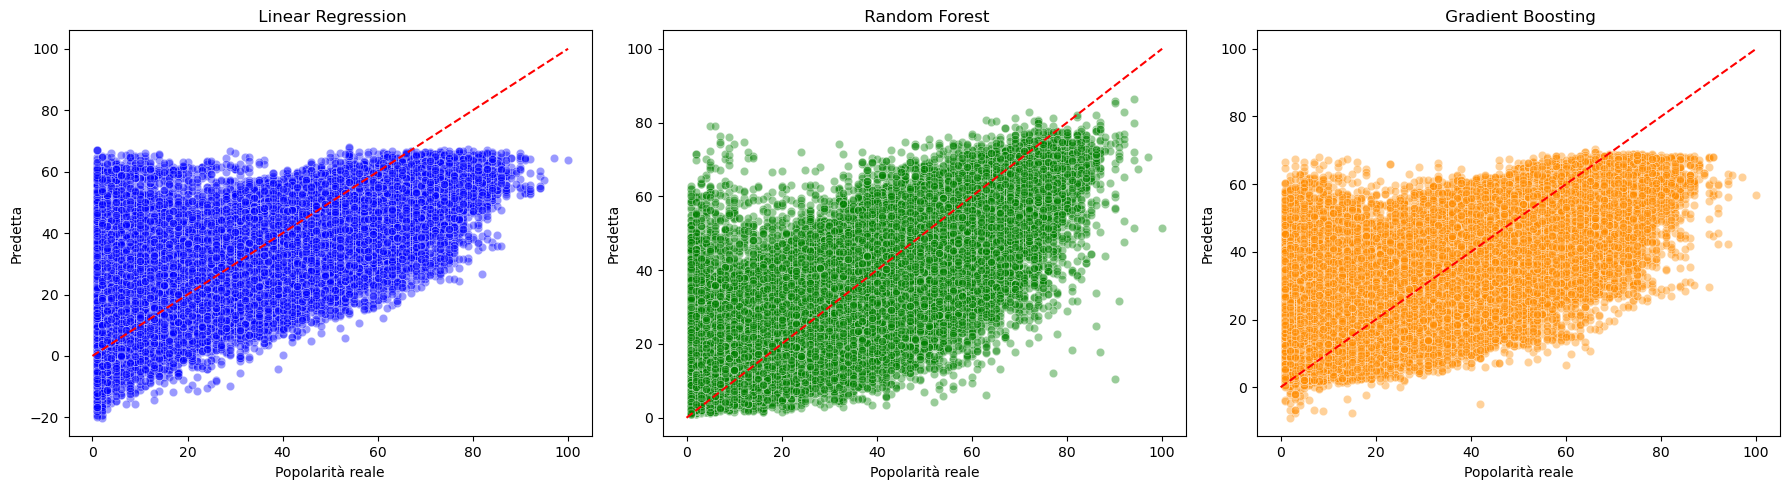

In [147]:

plt.figure(figsize=(18,5))

plt.subplot(1, 3, 1)
sns.scatterplot(x=y_test, y=y_pred_lr, alpha=0.4, color='blue')
plt.plot([0, 100], [0, 100], '--r')
plt.title(" Linear Regression")
plt.xlabel("Popolarità reale")
plt.ylabel("Predetta")

plt.subplot(1, 3, 2)
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.4, color='green')
plt.plot([0, 100], [0, 100], '--r')
plt.title(" Random Forest")
plt.xlabel("Popolarità reale")
plt.ylabel("Predetta")

plt.subplot(1, 3, 3)
sns.scatterplot(x=y_test, y=y_pred_gb, alpha=0.4, color='darkorange')
plt.plot([0, 100], [0, 100], '--r')
plt.title(" Gradient Boosting")
plt.xlabel("Popolarità reale")
plt.ylabel("Predetta")

plt.tight_layout()
plt.show()

##  Predizione della popolarità degli artisti Spotify usando i generi musicali
### Obiettivo
Costruire modelli di regressione in grado di prevedere la popolarità di un artista basandosi su:
- Il numero di follower
- I generi musicali associati all’artista (tramite one-hot encoding)
### Preparazione dei dati
1.	Filtro dei dati:
- Rimosso ogni artista con generi pari a ['unknown'].
2.	Pulizia dei generi:
- Eliminati i generi 'unknown' da ogni lista di generi.
- Calcolata la frequenza di tutti i generi presenti.
- Selezionati i 50 generi più frequenti.
- Gli altri generi meno frequenti sono stati unificati sotto l’etichetta 'other'.
3.	One-Hot Encoding:
-	Applicato MultiLabelBinarizer per trasformare i generi in colonne binarie (0/1).

In [148]:

artists_filtered = artists[artists['genres_list'].apply(lambda x: x != ['unknown'])].copy()

def remove_unknown(genres):
    return [g for g in genres if g != 'unknown']

artists_filtered['genres_filtered'] = artists_filtered['genres_list'].apply(remove_unknown)

all_genres = [genre for sublist in artists_filtered['genres_filtered'] for genre in sublist]
genre_counts = Counter(all_genres)
top_genres = [g for g, _ in genre_counts.most_common(50)]

def filter_genres(genres):
    return [g if g in top_genres else 'other' for g in genres]

artists_filtered['genres_filtered'] = artists_filtered['genres_filtered'].apply(filter_genres)

mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(artists_filtered['genres_filtered'])
genre_df = pd.DataFrame(genre_encoded, columns=mlb.classes_, index=artists_filtered.index)

artists_encoded = pd.concat([artists_filtered, genre_df], axis=1)

features = ['followers'] + list(mlb.classes_)
target = 'popularity'

df_clean = artists_encoded.dropna(subset=features + [target])

X = df_clean[features]
y = df_clean[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [149]:
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest")
print(f"MSE: {mean_squared_error(y_test, y_pred_rf):.2f}")
print(f"R²: {r2_score(y_test, y_pred_rf):.3f}\n")

rf_importance = get_feature_importance(rf, X.columns)
print("\n feature - Random Forest")
display(rf_importance.head(15))


Random Forest
MSE: 84.84
R²: 0.726


 feature - Random Forest


,feature,importance
0,followers,0.975775
4,calming instrumental,0.004202
33,other,0.003839
28,lo-fi beats,0.002324
3,background music,0.002322
5,classical performance,0.001687
49,tropical house,0.000731
36,pop edm,0.000630
20,indian classical,0.000542
35,pop dance,0.000433


In [150]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Regressione Lineare")
print(f"MSE: {mean_squared_error(y_test, y_pred_lr):.2f}")
print(f"R²: {r2_score(y_test, y_pred_lr):.3f}\n")

lr_importance = get_feature_importance(lr, X.columns)
print("\n feature - Regressione Lineare")
display(lr_importance.head(15))

Regressione Lineare
MSE: 259.16
R²: 0.162


 feature - Regressione Lineare


,feature,importance
28,lo-fi beats,34.649786
6,corrido,32.842061
25,k-pop,29.821897
15,french hip hop,29.342963
1,adult standards,28.816317
32,otacore,27.481731
17,german hip hop,27.245187
14,filmi,27.121971
18,german pop,26.350339
5,classical performance,26.173050


In [151]:
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

print("Gradient Boosting")
print(f"MSE: {mean_squared_error(y_test, y_pred_gb):.2f}")
print(f"R²: {r2_score(y_test, y_pred_gb):.3f}")

gb_importance = get_feature_importance(gb, X.columns)
print("\n feature - Gradient Boosting")
display(gb_importance.head(15))


Gradient Boosting
MSE: 75.41
R²: 0.756

 feature - Gradient Boosting


,feature,importance
0,followers,0.981578
33,other,0.004443
4,calming instrumental,0.003725
3,background music,0.002617
28,lo-fi beats,0.002342
5,classical performance,0.001644
49,tropical house,0.000633
36,pop edm,0.000501
34,pop,0.000386
35,pop dance,0.000361


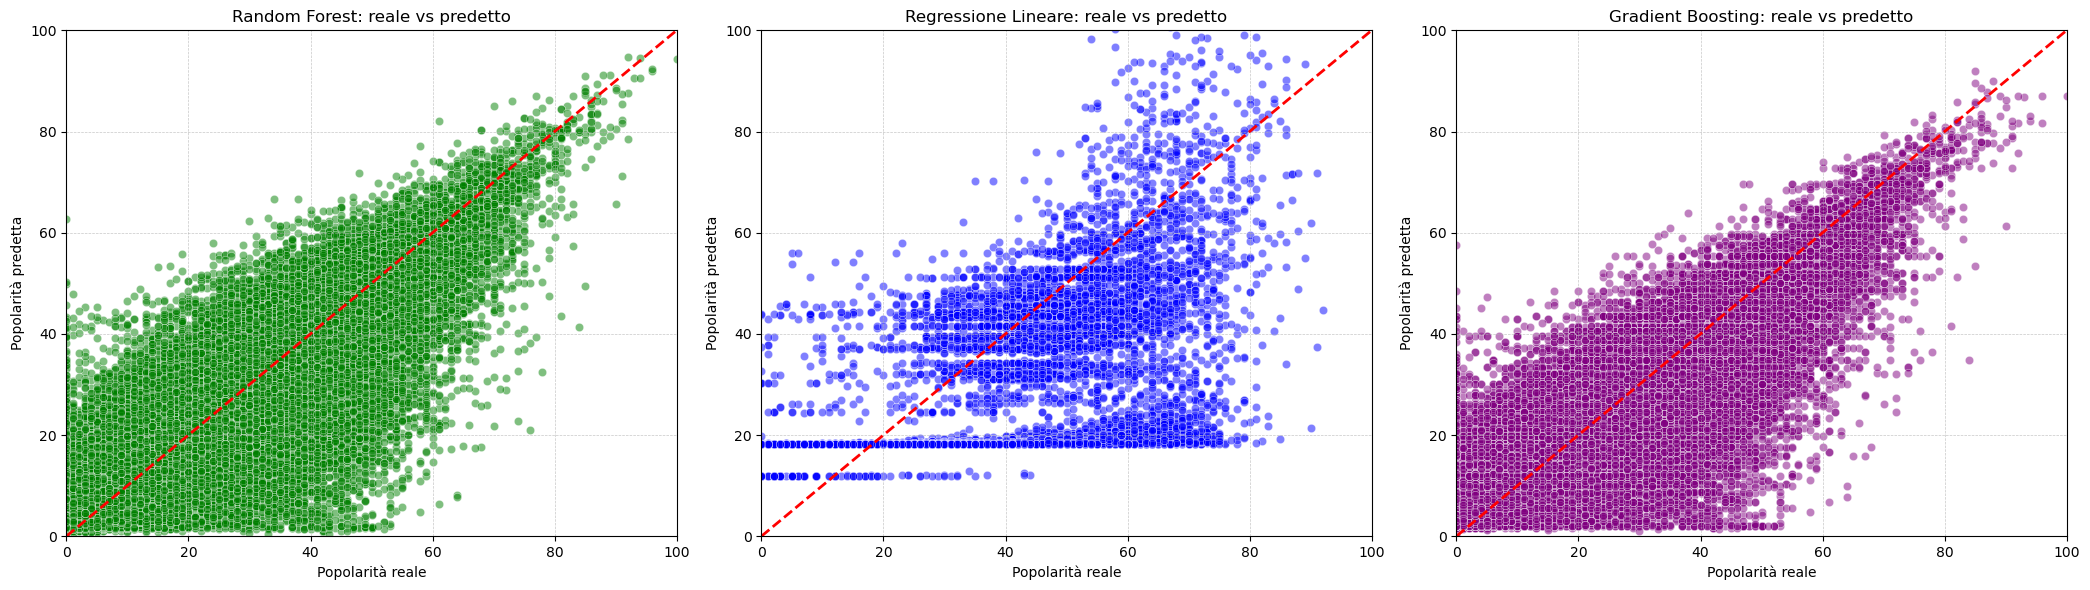

In [152]:
plt.figure(figsize=(21,6))

plt.subplot(1,3,1)
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.5, color='green')
plt.plot([0, 100], [0, 100], linestyle='--', color='red', linewidth=2)
plt.title("Random Forest: reale vs predetto")
plt.xlabel("Popolarità reale")
plt.ylabel("Popolarità predetta")
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

plt.subplot(1,3,2)
sns.scatterplot(x=y_test, y=y_pred_lr, alpha=0.5, color='blue')
plt.plot([0, 100], [0, 100], linestyle='--', color='red', linewidth=2)
plt.title("Regressione Lineare: reale vs predetto")
plt.xlabel("Popolarità reale")
plt.ylabel("Popolarità predetta")
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

plt.subplot(1,3,3)
sns.scatterplot(x=y_test, y=y_pred_gb, alpha=0.5, color='purple')
plt.plot([0, 100], [0, 100], linestyle='--', color='red', linewidth=2)
plt.title("Gradient Boosting: reale vs predetto")
plt.xlabel("Popolarità reale")
plt.ylabel("Popolarità predetta")
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

In questa fase, è stata eseguita una ricerca degli iperparametri per migliorare le prestazioni del modello di regressione GradientBoostingRegressor(migliore dei 3 precedenti), utilizzando RandomizedSearchCV di scikit-learn.

### Obiettivo

Trovare la migliore combinazione di iperparametri che minimizza l’errore quadratico medio (MSE) nella previsione della popolarità di un artista sulla base di caratteristiche come:
	•	Numero di follower
	•	Generi (codificati con one-hot encoding)

⸻

### Metodo Utilizzato
Tecnica di ottimizzazione:
- RandomizedSearchCV, che seleziona combinazioni casuali da distribuzioni predefinite per:
- n_estimators (numero di alberi)
- learning_rate (tasso di apprendimento)
- max_depth (profondità massima di ogni albero)
- subsample (percentuale di campioni da usare)
- min_samples_split (minimo numero di campioni per dividere un nodo)

Validazione:
- Cross-validation a 3 fold
- 20 iterazioni totali su combinazioni casuali 

Sono state utilizzate solo 20 combinazioni casuali per ridurre il tempo computazionale. Aumentando il numero di combinazioni testate si potrebbe ottenere un miglioramento marginale delle prestazioni, ma a fronte di un tempo di calcolo più elevato.

In [153]:

param_dist = {
    'n_estimators': randint(50, 200),
    'learning_rate': uniform(0.05, 0.2),
    'max_depth': randint(3, 7),
    'subsample': uniform(0.8, 0.2),
    'min_samples_split': randint(2, 6)
}

gb = GradientBoostingRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=gb,
    param_distributions=param_dist,
    n_iter=20,             
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search.fit(X_train, y_train)


best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\n Risultati RandomizedSearch:")
print("Best params:", random_search.best_params_)
print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"R²: {r2_score(y_test, y_pred):.3f}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END learning_rate=0.16937003158929742, max_depth=4, min_samples_split=4, n_estimators=124, subsample=0.8918497783931735; total time=  19.9s
[CV] END learning_rate=0.1249080237694725, max_depth=3, min_samples_split=4, n_estimators=156, subsample=0.9559382000545539; total time=  19.9s
[CV] END learning_rate=0.16937003158929742, max_depth=4, min_samples_split=4, n_estimators=124, subsample=0.8918497783931735; total time=  20.0s
[CV] END learning_rate=0.1249080237694725, max_depth=3, min_samples_split=4, n_estimators=156, subsample=0.9559382000545539; total time=  20.0s
[CV] END learning_rate=0.16937003158929742, max_depth=4, min_samples_split=4, n_estimators=124, subsample=0.8918497783931735; total time=  20.2s
[CV] END learning_rate=0.1249080237694725, max_depth=3, min_samples_split=4, n_estimators=156, subsample=0.9559382000545539; total time=  20.9s
[CV] END learning_rate=0.2484423118582435, max_depth=3, min_samples_spli